In [416]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [417]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=(FutureWarning, ConvergenceWarning, UserWarning))

In [418]:
df = pd.read_csv(r'npf_train.csv')
df.head()

,id,date,class4,partlybad,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,...,T672.mean,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std
0,1,2000-01-17,Ib,False,368.771711,0.310309,368.665658,0.305127,369.371184,0.333606,...,-1.476016,0.250952,-0.899393,0.271648,2.492491,1.310880,0.031587,0.018122,0.000243,0.000035
1,2,2000-02-28,nonevent,False,378.197295,1.001493,378.083089,1.025472,378.671311,1.017208,...,1.479493,0.313460,2.033191,0.271090,0.295937,0.177836,0.005140,0.003552,0.003658,0.000940
2,3,2000-03-24,Ib,False,373.043158,0.749865,372.930066,0.728411,373.569735,0.835240,...,-0.270844,2.037111,0.780422,2.334741,14.434789,8.627312,0.353743,0.272472,0.000591,0.000191
3,4,2000-03-30,II,False,375.643019,0.558629,375.549430,0.540964,376.045849,0.580730,...,5.622308,2.509758,6.533544,2.695277,16.077513,9.984686,0.568242,0.451830,0.002493,0.000466
4,5,2000-04-04,nonevent,False,377.661030,0.408421,377.609576,0.423963,378.117134,0.417243,...,1.140121,1.438071,2.133774,1.614122,9.710422,7.054069,0.339135,0.291457,0.004715,0.000679


### Data Preprocessing

In [419]:
df = df.drop(["partlybad", "date", "id"], axis = 1)

We looked at the training dataset and found out that there is only one unique
value (’False’) for a variable ’partlybad’. Therefore it can be removed. In addition, when examining the test data, we found that the variable ’date’ is hidden.
Consequently, we cannot use it for fitting the model.

In [420]:
df['class2'] = np.where(df['class4'] == 'nonevent', 0, 1)

In [421]:
from sklearn.preprocessing import OrdinalEncoder

ohe = OrdinalEncoder()
df['class4'] = ohe.fit_transform(df['class4'].to_numpy().reshape(-1, 1))

### Data Analysis: Problems and Issues

In [422]:
X = df.drop(['class2', 'class4'], axis = 1)

Text(0.5, 1.0, 'The number of datapoints for each class.')

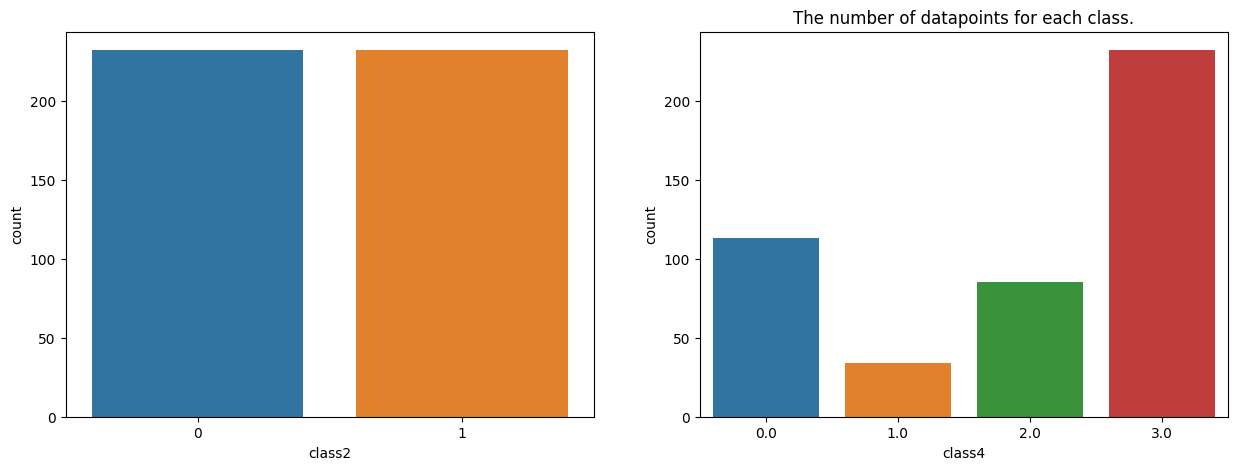

In [423]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

sns.countplot(x = 'class2', data = df, ax = axes[0])
sns.countplot(x = 'class4', data = df, ax = axes[1])

plt.title('The number of datapoints for each class.')

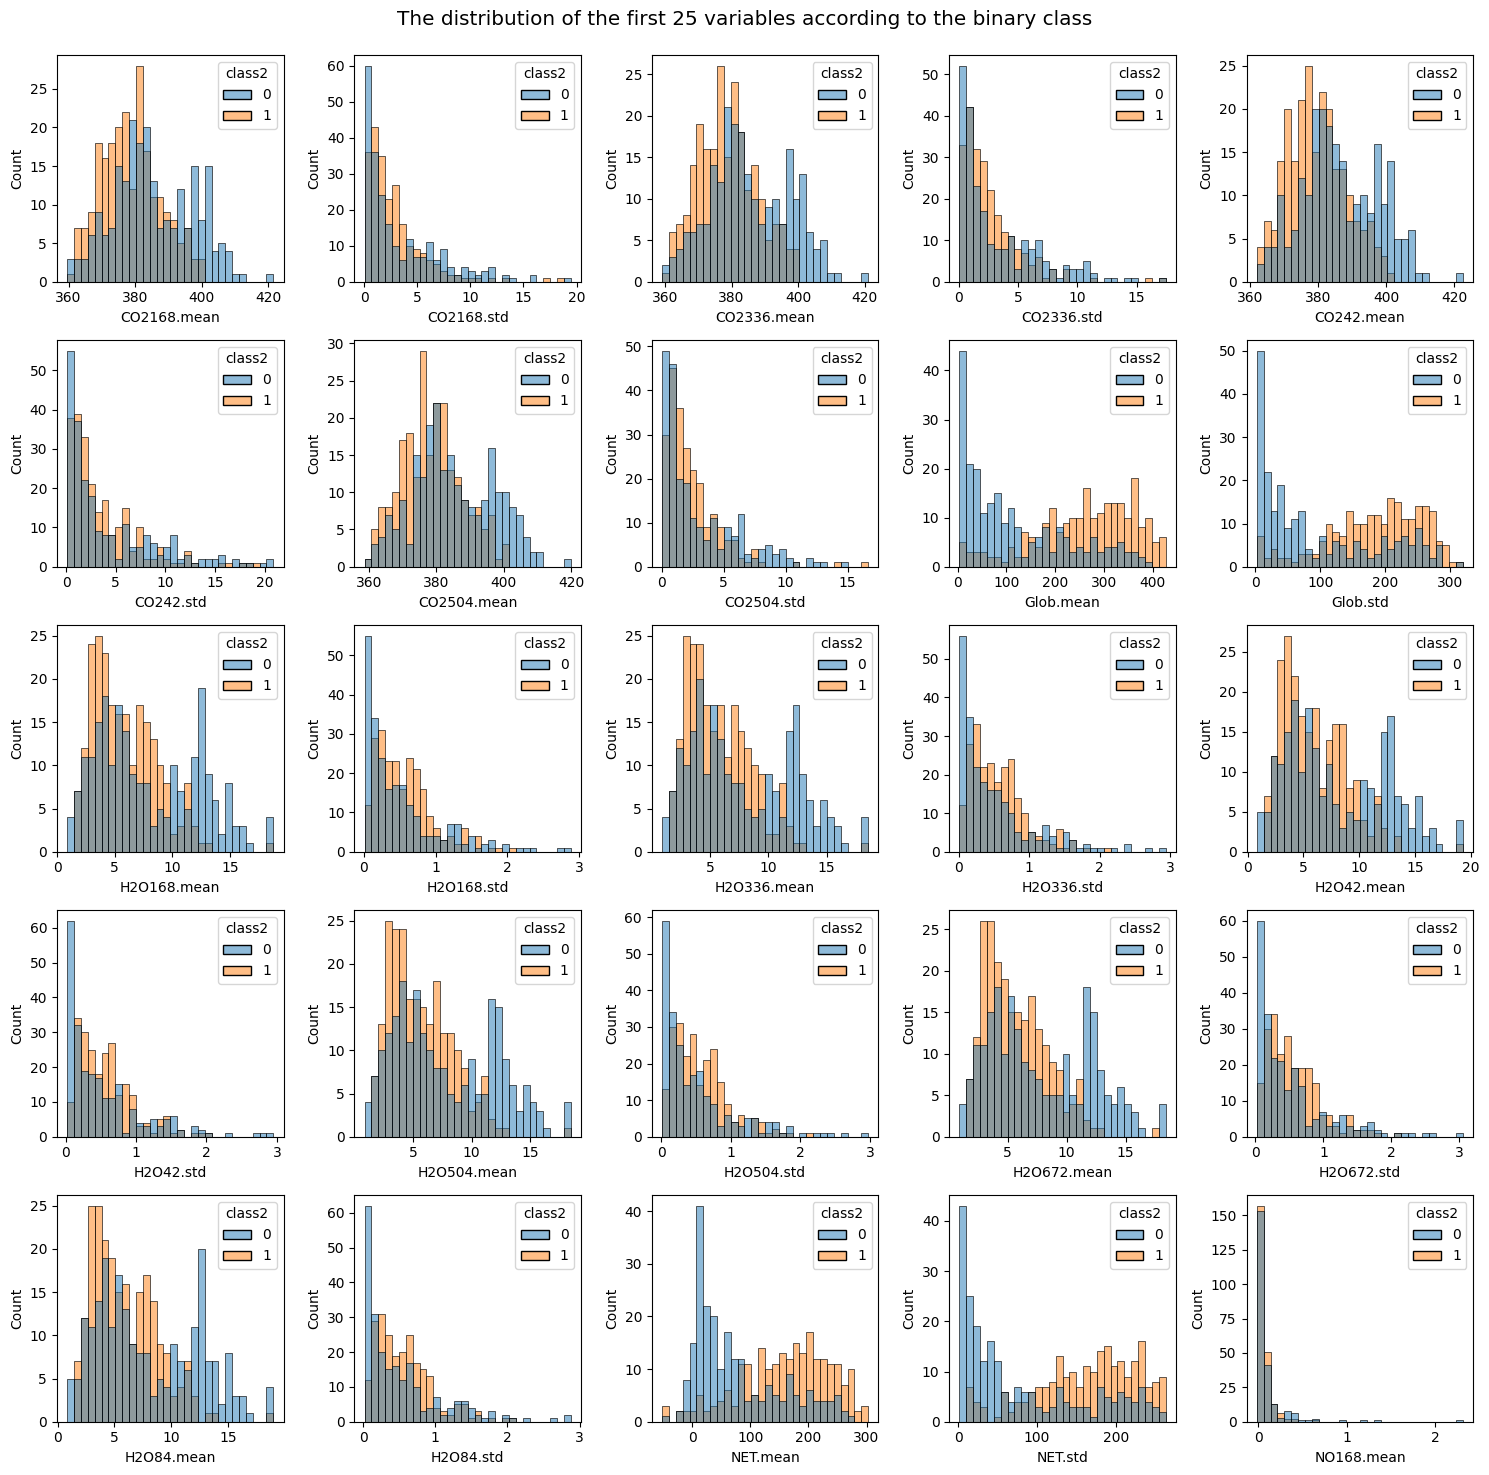

In [424]:
_, axes = plt.subplots(5, 5, figsize=(15, 15))
ax = axes.ravel()     

for index, i in enumerate(X.columns[:25]):                   
    sns.histplot(x=i, data=df, ax=ax[index], hue='class2', bins = 30)
    
plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.suptitle('The distribution of the first 25 variables according to the binary class', \
    fontsize = 'x-large')

plt.show()

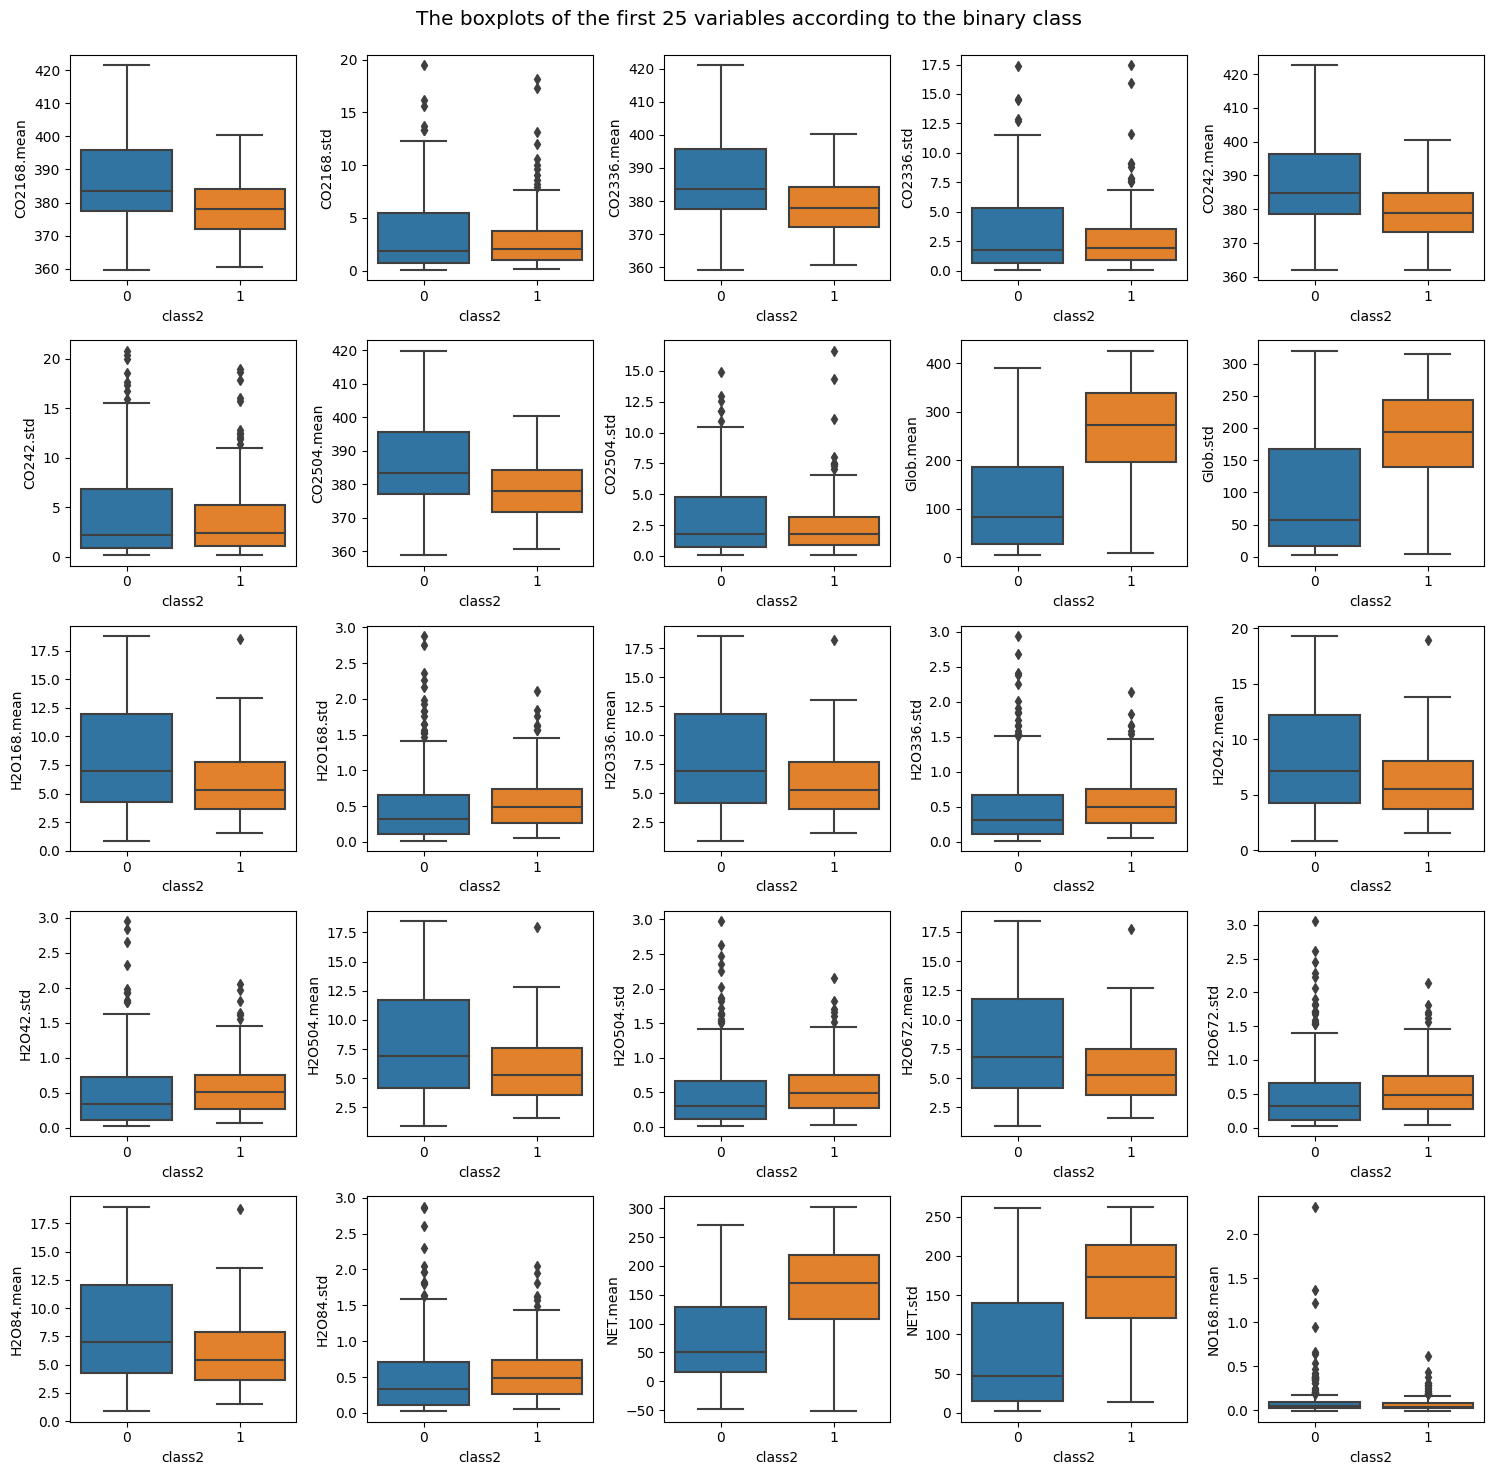

In [425]:
_, axes = plt.subplots(5, 5, figsize=(15, 15))
ax = axes.ravel()     

for index, i in enumerate(X.columns[:25]):                   
    sns.boxplot(x='class2', y = i, data=df, ax=ax[index])
    
plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.suptitle('The boxplots of the first 25 variables according to the binary class', \
    fontsize = 'x-large')

plt.show()

In [426]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
''' VIF value for the first 15 variables.'''

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

vif_data.head(15)

,feature,VIF
0,CO2168.mean,1.194166e+07
1,CO2168.std,5.745440e+02
2,CO2336.mean,3.353975e+07
3,CO2336.std,1.237758e+03
4,CO242.mean,1.141838e+06
5,CO242.std,1.096593e+02
6,CO2504.mean,1.476287e+07
7,CO2504.std,6.097091e+02
8,Glob.mean,3.614554e+03
9,Glob.std,5.784113e+03


#### Conclusion:

- Quite small dataset: Due to the small size of the dataset, we should be
careful with model selection and not use complex architectures (such as neural networks) to avoid overfitting.

- Outliers: (Based on Figure 3) We should remove the outliers to improve
the accuracy of the models.

- Imbalanced data for multi-class prediction: (Based on Figure 1) Ignored data imbalance can greatly affect the accuracy of the results. It is worth
processing the data before training the model.

- Large number of variables. Multicollinearity: (Based on Figures 2, 4) Multicollinearity is noticeable when the VIF value is large, as well as when finding similar distribution plots. It is worth either reducing the number of variables or using various automatic algorithms (e.g. PCA, Regularization etc.)


### Method: Choosing model

Dealing with the outliers: In our work we used Unsupervised Outlier Detection using the Local Outlier Factor (class LocalOutlierFactor from sklearn.neighbors). The analysis revealed 12 outliers. After the removal the shape is (452, 102).


In [427]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor()
res = clf.fit_predict(X)

index = [index for index, r in enumerate(res) if r == -1]

df = df.drop(index)
print(df.shape)

(452, 102)


Next, we decided to deal with two different problems: Binary and Multi-class Classification. First we will define the binary class of the datapoint, and then (in case of detecting an event) the multi-class label. If we predict both binary and multi-class labels, the models may predict different classes (e.g. ’nonevent’ and ’Ia’), which is completely contrary to our goals.

#### Binary classification

In [428]:
X = df.drop(['class2', 'class4'], axis = 1)
y = df['class2']

For binary classification we decided to test the accuracy of such models:
GaussianNB, SVC, RandomForestClassifier, DecisionTreeClassifier, QDA, KNeighborsClassifier, LogisticRegression.

We fitted the models and tuned hyperparameters with 20-fold Cross-Validation algorithm (using class GridSearchCV from sklearn.model selection). The hyperparameters for each model will be presented below, as well as lists of parameter settings to try as values. Also the top 3 best models and their accuracy will be reported accordingly.

In [429]:
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

models = {
    'GaussianNB': GaussianNB(),
    'KNN': KNeighborsClassifier(), 
    'Decision Tree': DecisionTreeClassifier(), 
    'LDA': LinearDiscriminantAnalysis(), 
    'QDA': QuadraticDiscriminantAnalysis()
    }

In [430]:
res = pd.DataFrame(columns = ['Name', 'Accuracy', 'Hyperparameters'])

for name, model in models.items():
    grid = GridSearchCV(model, {}, cv = 20)
    grid.fit(X, y)

    row = {'Name': name, 'Accuracy': grid.cv_results_['mean_test_score'][0]}
    res = res.append(row, ignore_index=True)

res.sort_values(by = 'Accuracy', ascending = False)

,Name,Accuracy,Hyperparameters
3,LDA,0.878854,NaN
4,QDA,0.836759,NaN
2,Decision Tree,0.825494,NaN
1,KNN,0.787648,NaN
0,GaussianNB,0.786265,NaN


In [431]:
def grid_search_tuning(res, models, parameters, model, X, y, cv):      
    grid = GridSearchCV(model(), parameters, cv = cv)
    grid.fit(X, y)

    parameters_list = ['param_' + key for key in parameters.keys()]
    res_list = list(zip(*[grid.cv_results_[param] for param in parameters_list] + [grid.cv_results_['mean_test_score']]))

    res_df = pd.DataFrame(res_list, columns = list(parameters.keys()) + ['score'])
    res_df = res_df.sort_values(by = 'score', ascending = False)

    zipped_lists = zip(parameters.keys(), res_list[0][:-1])
    parameter_strings = [f"{a} = {b}" for (a, b) in zipped_lists]
    parameter_strings = ", ".join(parameter_strings)

    row = {'Name': model.__name__, 'Accuracy': res_list[0][-1], 'Hyperparameters': parameter_strings}
    res = res.append(row, ignore_index=True)

    kwargs = dict(zip(parameters.keys(), res_list[0][:-1]))
    models[model.__name__] = model(**kwargs)

    return res, models

In [432]:
parameters = {'C': [10000, 1000, 100, 10, 5, 1, 0.5, 0.1], \
    'degree': [1, 2, 3, 4]}

res, models = grid_search_tuning(res, models, parameters, SVC, X, y, 20)

In [433]:
parameters = {'C': [1000, 100, 10, 5, 1, 0.5, 0.1, 0.001, 0.001], \
    'fit_intercept': [True, False]}

res, models = grid_search_tuning(res, models, parameters, LogisticRegression, X, y, 20)

In [434]:
parameters = {'max_depth': [5, 6, 7, 8, 9], \
    'n_estimators': [2, 4, 8, 16, 32]}

res, models = grid_search_tuning(res, models, parameters, RandomForestClassifier, X, y, 20)

In [435]:
res.sort_values(by = 'Accuracy', ascending = False)

,Name,Accuracy,Hyperparameters
3,LDA,0.878854,NaN
6,LogisticRegression,0.848123,"C = 1000, fit_intercept = True"
5,SVC,0.838636,"C = 10000, degree = 1"
4,QDA,0.836759,NaN
2,Decision Tree,0.825494,NaN
1,KNN,0.787648,NaN
0,GaussianNB,0.786265,NaN
7,RandomForestClassifier,0.785672,"max_depth = 5, n_estimators = 2"


We did not select hyperparameters for the all models, since the initial result of some models was significantly lower compared to others. It is obvious that because of multicollinearity naive Bayes assumption does not work, hence the accuracy is quite low and we could not use this model. KNN classifier is too ’simple’ for this type of task. Decision tree showed lower results compared to the Random forest, so we will not use this algorithm too.

Also based on the results, we can see that polynomials not of the first degree show better results in the case of SVM. Therefore, we decided to additionally check the polynomials of the second and third degree for LogisticRegression.

In [436]:
from sklearn.preprocessing import PolynomialFeatures

parameters = {'C': [1000, 100, 10, 5, 1, 0.5, 0.1, 0.001, 0.001], \
    'fit_intercept': [True, False]}

poly = PolynomialFeatures(degree = 2)
X_poly = poly.fit_transform(X)

log_reg = LogisticRegression()
grid = GridSearchCV(log_reg, parameters, cv = 20)

grid.fit(X_poly, y)
res_list = list(zip(grid.cv_results_['param_C'], grid.cv_results_['param_fit_intercept'], grid.cv_results_['mean_test_score']))

res_df = pd.DataFrame(res_list, columns = ['C', 'fit_intercept', 'score'])
res_df = res_df.sort_values(by = 'score', ascending = False)
res_df.head(5)

,C,fit_intercept,score
1,1000.0,False,0.850395
5,10.0,False,0.850395
6,5.0,True,0.850198
2,100.0,True,0.848320
10,0.5,True,0.848221


In [437]:
parameters = {'C': [1000, 100, 10, 0.1, 0.01, 0.001], \
    'fit_intercept': [True, False]}

poly = PolynomialFeatures(degree = 3)
X_poly = poly.fit_transform(X)

log_reg = LogisticRegression()
grid = GridSearchCV(log_reg, parameters, cv = 3)

grid.fit(X_poly, y)
res_list = list(zip(grid.cv_results_['param_C'], grid.cv_results_['param_fit_intercept'], grid.cv_results_['mean_test_score']))

res_df = pd.DataFrame(res_list, columns = ['C', 'fit_intercept', 'score'])
res_df = res_df.sort_values(by = 'score', ascending = False)
res_df.head(5)

,C,fit_intercept,score
6,0.100,True,0.798690
7,0.100,False,0.798690
10,0.001,True,0.798661
11,0.001,False,0.798661
9,0.010,False,0.796453


In [438]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

''' Using Principal component analysis with scaling data '''
pca_scaler = []
for name, model in models.items():
    pipeline = make_pipeline(StandardScaler(), PCA(n_components = 13), model)
    
    grid = GridSearchCV(pipeline, {}, cv = 20)
    grid.fit(X, y)

    pca_scaler.append(grid.cv_results_['mean_test_score'][0])

res['PCA + Scaler'] = pca_scaler

In [439]:
''' Models with just scaling data '''

pca_scaler = []
for name, model in models.items():
    pipeline = make_pipeline(StandardScaler(), model)
    
    grid = GridSearchCV(pipeline, {}, cv = 20)
    grid.fit(X, y)

    pca_scaler.append(grid.cv_results_['mean_test_score'][0])

res['Scaler'] = pca_scaler

In [440]:
''' Choosing only mean / std values '''

variables = set()

for name in X.columns:
    variables.add(name.split('.')[0])

X_mean = X[[var + '.mean' for var in variables]]
X_std = X[[var + '.std' for var in variables]]

mean, std = [], []
for name, model in models.items():    
    grid_mean = GridSearchCV(pipeline, {}, cv = 20)
    grid_mean.fit(X, y)
    mean.append(grid_mean.cv_results_['mean_test_score'][0])

    grid_std = GridSearchCV(pipeline, {}, cv = 20)
    grid_std.fit(X, y)
    std.append(grid_std.cv_results_['mean_test_score'][0])

res['Only mean'] = mean
res['Only std'] = std

In [441]:
res.sort_values(by = 'Accuracy', ascending = False)

,Name,Accuracy,Hyperparameters,PCA + Scaler,Scaler,Only mean,Only std
3,LDA,0.878854,NaN,0.865514,0.878854,0.789822,0.795751
6,LogisticRegression,0.848123,"C = 1000, fit_intercept = True",0.860968,0.845553,0.807609,0.801482
5,SVC,0.838636,"C = 10000, degree = 1",0.847233,0.873518,0.805435,0.840711
4,QDA,0.836759,NaN,0.839229,0.836759,0.814526,0.825395
2,Decision Tree,0.825494,NaN,0.796937,0.796542,0.836067,0.785277
1,KNN,0.787648,NaN,0.819071,0.843379,0.832016,0.822530
0,GaussianNB,0.786265,NaN,0.810573,0.786265,0.807411,0.803261
7,RandomForestClassifier,0.785672,"max_depth = 5, n_estimators = 2",0.779051,0.805731,0.801285,0.807016


#### Multi-class prediction

In [442]:
event_df = df[df['class4'] != 3]

X = event_df.drop(['class2', 'class4'], axis = 1)
y = event_df['class4']

<AxesSubplot: xlabel='class4', ylabel='count'>

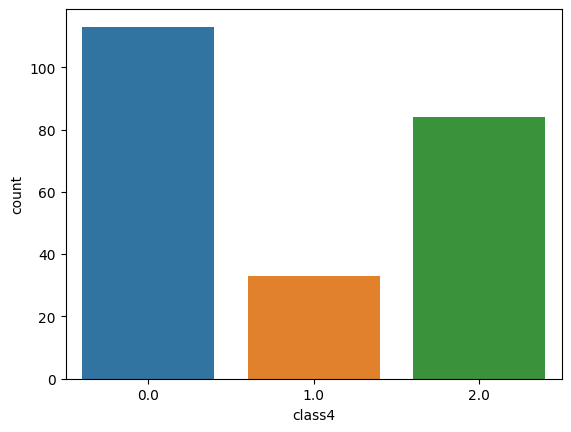

In [443]:
sns.countplot(data = X, x = y)

In [444]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X, y)

<AxesSubplot: xlabel='class4', ylabel='count'>

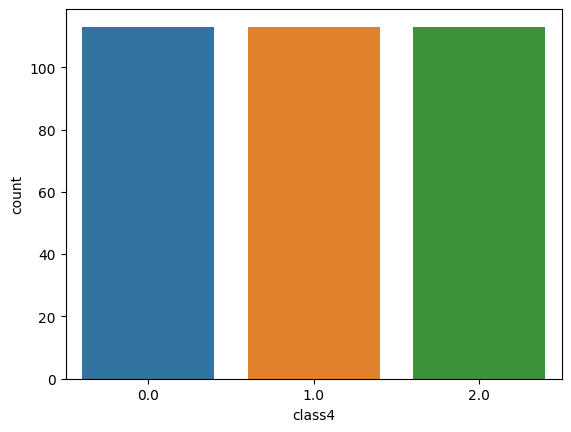

In [445]:
sns.countplot(data = X_train, x = y_train)

In [446]:
models_multi = {
    'GaussianNB': GaussianNB(),
    'KNN': KNeighborsClassifier(), 
    'Decision Tree': DecisionTreeClassifier(), 
    'LDA': LinearDiscriminantAnalysis(), 
    'QDA': QuadraticDiscriminantAnalysis()
    }

res_multi = pd.DataFrame(columns = ['Name', 'Accuracy', 'Hyperparameters'])

for name, model in models_multi.items():
    grid = GridSearchCV(model, {}, cv = 20)
    grid.fit(X_train, y_train)

    row = {'Name': name, 'Accuracy': grid.cv_results_['mean_test_score'][0]}
    res_multi = res_multi.append(row, ignore_index=True)

res_multi.sort_values(by = 'Accuracy', ascending = False)

,Name,Accuracy,Hyperparameters
4,QDA,0.826471,NaN
2,Decision Tree,0.735294,NaN
3,LDA,0.617279,NaN
1,KNN,0.557721,NaN
0,GaussianNB,0.455147,NaN


In [447]:
parameters = {'C': [10000, 1000, 100, 10, 5, 1, 0.5, 0.1], \
    'degree': [1, 2, 3, 4]}

res_multi, models_multi = grid_search_tuning(res_multi, models_multi, parameters, SVC, X_train, y_train, 20)

In [448]:
parameters = {'C': [1000, 100, 10, 5, 1, 0.5, 0.1, 0.001, 0.001], \
    'fit_intercept': [True, False]}

res_multi, models_multi = grid_search_tuning(res_multi, models_multi, parameters, LogisticRegression, X_train, y_train, 20)

In [449]:
parameters = {'max_depth': [5, 6, 7, 8, 9], \
    'n_estimators': [2, 4, 8, 16, 32]}

res_multi, models_multi = grid_search_tuning(res_multi, models_multi, parameters, RandomForestClassifier, X_train, y_train, 20)

In [450]:
res_multi.sort_values(by = 'Accuracy', ascending = False)

,Name,Accuracy,Hyperparameters
4,QDA,0.826471,NaN
2,Decision Tree,0.735294,NaN
5,SVC,0.664154,"C = 10000, degree = 1"
3,LDA,0.617279,NaN
7,RandomForestClassifier,0.616544,"max_depth = 5, n_estimators = 2"
1,KNN,0.557721,NaN
6,LogisticRegression,0.534743,"C = 1000, fit_intercept = True"
0,GaussianNB,0.455147,NaN


### Summary

Step-by-step:
- Removed the outliers with Unsupervised Outlier Detection.
- Standardized features by removing the mean and scaled to unit variance.
- Predicted the ’event’, ’nonevent’ days with LDA model.
- Predicted the type of the ’event’ days with QDA.
- ’Merged’ the output from 2 models.

In [471]:
df_test = pd.read_csv(r'npf_test.csv')
df_test = df_test.drop(["partlybad", "date", "id"], axis = 1)

In [472]:
df_test['class2'] = np.where(df_test['class4'] == 'nonevent', 0, 1)

In [473]:
df_test['class4'] = ohe.fit_transform(df_test[['class4']])

In [474]:
pipeline_binary = make_pipeline(StandardScaler(), models['LDA'])

pipeline_binary.fit(df.drop(['class4', 'class2'], axis = 1), df['class2'])
y = pipeline_binary.predict(df_test.drop(['class4', 'class2'], axis = 1))

In [484]:
pipeline_multi = make_pipeline(models_multi['QDA'])

event = df[df['class4'] != 3]
X_train, y_train = ros.fit_resample(event.drop(['class4', 'class2'], axis = 1), event['class4'])

pipeline_multi.fit(X_train, y_train)
y_multi = pipeline_multi.predict(df_test.drop(['class4', 'class2'], axis = 1))

In [491]:
y_multi = np.where(y == 0, 3, y_multi)
accuracy_binary = np.sum(y == df_test['class2']) / df_test.shape[0]
accuracy_multi = np.sum(y_multi == df_test['class4']) / df_test.shape[0]
accuracy_binary, accuracy_multi

(0.8518134715025907, 0.6621761658031088)